# Análisis de Clustering y Optimización de Portafolios

## Sección 1: Importación de bibliotecas y definición de Tickers

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize
from scipy.stats import dirichlet
import joblib

### Definición de Tickers:

Se define una lista de `TICKERS` que representa las acciones de varias industrias:
- Tecnología, Salud, Energía, Finanzas, Consumo, etc.
- Estos tickers se utilizan para descargar datos históricos de precios.

In [2]:
TICKERS = [
    # Tecnología
    'AAPL', 'MSFT', 'GOOGL', 'NVDA','AMZN', 'META', 'INTC', 'AMD', 'CSCO',

    # Salud
    'JNJ', 'PFE', 'MRK', 'UNH', 'ABBV', 'BMY', 'GILD', 'REGN', 'VRTX', 'LLY',

    # Energía (Energy)
    'XOM', 'CVX', 'SLB', 'BP', 'COP', 'OXY', 'EOG', 'KMI', 'PSX', 'HAL',

    # Finanzas
    'JPM', 'GS', 'BRK-B', 'C', 'BAC', 'WFC', 'MS', 'AXP', 'BLK', 'SCHW',

    # Consumo Básico
    'KO', 'PEP', 'PG', 'WMT', 'MO', 'CL', 'KMB', 'EL', 'STZ', 'COST',

    # Consumo Discrecional
    'DIS', 'TSLA', 'NFLX', 'HD', 'NKE', 'SBUX', 'MCD', 'TGT', 'LOW',

    # Industriales
    'BA', 'CAT', 'UPS', 'LMT', 'MMM', 'GE', 'HON', 'DE', 'UNP', 'CSX',

    # Telecomunicaciones
    'VZ', 'T', 'TMUS', 'CHT', 'CMCSA', 'EA', 'NOK', 'ERIC', 'CCI', 'SBAC',

    # ETFs
    'SPY', 'QQQ', 'VTI', 'EWW', 'IEMG', 'EFA', 'VWO', 'IXC', 'XLE', 'XLF',
]

## Sección 2: Descarga de Datos y Preparación de Retornos

### Descarga de Datos:

- Usando `yfinance`, se descargan los precios de cierre de las acciones de los tickers definidos desde 2014 hasta 2024.
- La variable `datos` contiene el DataFrame con los precios de cierre.

In [3]:
datos = yf.download(TICKERS, start="2014-01-01", end="2024-12-31")['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  88 of 88 completed


### Cálculo de Retornos:

- Los retornos logarítmicos se calculan usando `np.log(datos / datos.shift(1))`.
- Los valores `NaN` generados por el cálculo de retornos son eliminados con `.dropna()`.

In [4]:
retornos = np.log(datos / datos.shift(1)).dropna()  # Eliminar NaN resultantes del cálculo

## Sección 3: Análisis de Correlación

### Matriz de Correlación:
- Se calcula la matriz de correlación entre los retornos de las acciones con `retornos.corr()`.
- Esta matriz muestra cómo se mueven juntas las acciones.

In [5]:
matriz_correlacion = retornos.corr()

### Visualización de la Correlación:
- Usando `seaborn.heatmap`, se genera una visualización en forma de mapa de calor de la matriz de correlación.
- Se ajusta el tamaño de la figura para una mejor visualización y se configura para eliminar los valores de las celdas (`annot=False`).

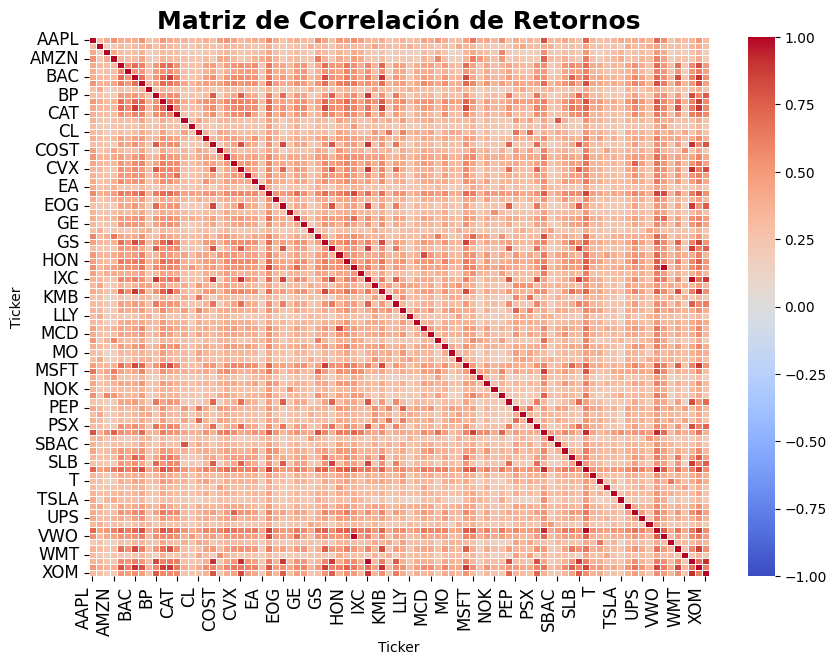

In [6]:
plt.figure(figsize=(10,7))

sns.heatmap(matriz_correlacion, annot=False, cmap='coolwarm',  # Eliminamos los valores
            vmin=-1, vmax=1,  # Limitar el rango de la barra de colores
            linewidths=0.5,  # Líneas entre celdas
            linecolor='white')  # Cambiar el color de las líneas de las celdas

plt.title("Matriz de Correlación de Retornos", fontsize=18, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=12)  # Aumentar el tamaño de las etiquetas de las columnas
plt.yticks(rotation=0, fontsize=12)  # Aumentar el tamaño de las etiquetas de las filas

plt.show()

## Sección 4: Clustering Jerárquico

### Normalización de los Datos:
- Se normalizan los datos de retornos con `StandardScaler` para que todas las acciones tengan un peso similar en el clustering, eliminando la escala original de los datos.

In [7]:
escalado = StandardScaler()
retornos_escalados = escalado.fit_transform(retornos.T)

### Matriz de Distancia:
- La matriz de correlación se convierte en una matriz de distancias con `1 - matriz_correlacion`.
- Luego, se transforma esta matriz en una forma condensada usando `squareform`

In [8]:
matriz_distancia = 1 - matriz_correlacion
# Convertir la matriz de distancia completa a una forma condensada
matriz_distancia_condensada = squareform(matriz_distancia)

### Generación del Dendrograma:
- Usando `scipy.cluster.hierarchy.linkage`, se calcula la estructura de los clusters (linkage) utilizando el método 'ward'.
- El dendrograma es una representación visual de cómo las acciones se agrupan a medida que la distancia entre ellas aumenta.
- Se encuentra el umbral óptimo de distancias (`umbral_optimo`) observando la diferencia entre distancias consecutivas en el linkage.

In [9]:
Z = linkage(matriz_distancia_condensada, method='ward')

# Calcular el número óptimo de clusters con el Dendrograma (usando el umbral óptimo)
distancias = Z[:, 2]  # Extraemos las distancias
diferencia_distancias = np.diff(distancias)  # Diferencia entre distancias consecutivas
indice_umbral = np.argmax(diferencia_distancias)  # Mayor salto en la distancia
umbral_optimo = distancias[indice_umbral]  # Umbral óptimo

# Usamos fcluster para obtener los clusters según el umbral
clusters = fcluster(Z, umbral_optimo, criterion='distance') 

### Visualización del Dendrograma:
- Se dibuja el dendrograma y se marca el umbral óptimo usando `plt.axhline`. Este umbral define cuántos clusters hay en el análisis.

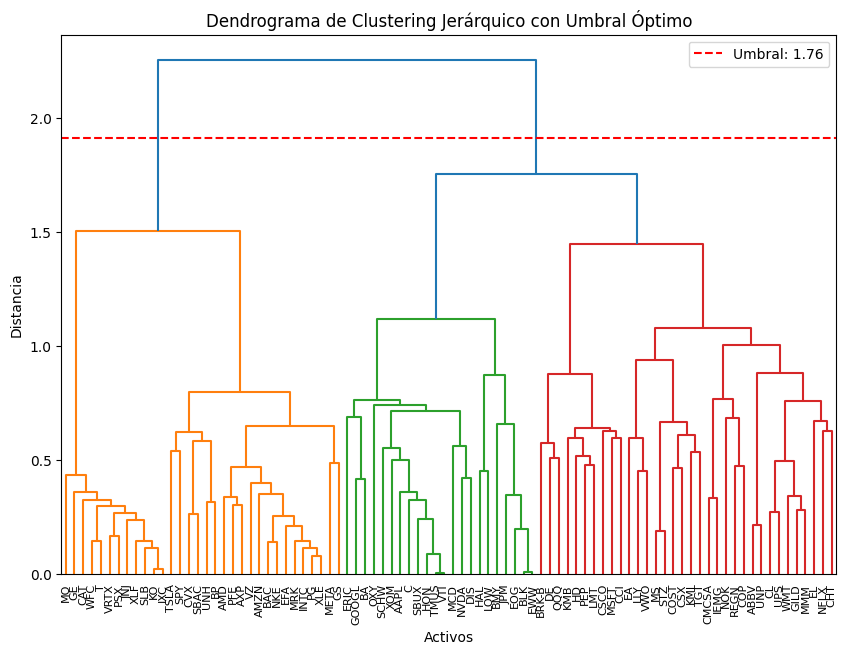

Número óptimo de clusters (Dendograma): 2
Umbral Óptimo: 1.76


In [10]:
# Obtener el número óptimo de clusters del dendrograma
k_optimo_dendograma = len(set(clusters))

# Graficar el Dendrograma con el umbral óptimo
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=TICKERS, leaf_rotation=90, leaf_font_size=8)
separacion = umbral_optimo * 1.09
plt.axhline(y=separacion, color='r', linestyle='--', label=f'Umbral: {umbral_optimo:.2f}')
plt.title("Dendrograma de Clustering Jerárquico con Umbral Óptimo")
plt.xlabel("Activos")
plt.ylabel("Distancia")
plt.legend()
plt.show()

# Imprimir el número óptimo de clusters del Dendrograma
print(f"Número óptimo de clusters (Dendograma): {k_optimo_dendograma}")
print(f"Umbral Óptimo: {umbral_optimo:.2f}")

## Sección 5: Evaluación de la Calidad del Clustering

### Cálculo del Silhouette Score:
- Se define una función para evaluar la calidad del clustering utilizando el índice de Silhouette, que mide qué tan bien se ajustan los puntos dentro de sus clusters.
- Se evalúan diferentes valores de `k` (número de clusters), métodos de linkage y métricas de distancia (euclidiana, manhattan, etc.), y se selecciona el mejor modelo con el mayor Silhouette Score.

In [11]:
def evaluar_silueta(k, metodo_conexion, metrica, datos):
    try:
        # Realizar el agrupamiento y calcular el Silhouette Score
        agrupamiento = AgglomerativeClustering(n_clusters=k, linkage=metodo_conexion)
        etiquetas = agrupamiento.fit_predict(datos)
        return silhouette_score(datos, etiquetas, metric=metrica)
    except Exception as e:
        print(f"Error evaluando k={k} con {metodo_conexion} y métrica {metrica}: {e}")
        return -1  # Retorna un valor inválido si hay un error

# Inicializamos las variables de evaluación
mejor_score = -1
k_optimo_silueta = 0

# Diccionario para almacenar los resultados solo para el mejor método de linkage y métrica
scores_silueta = {}

# El rango de k va desde un valor mínimo hasta un valor máximo dinámico
min_k = 3  # El mínimo de k, puedes ajustarlo según sea necesario
max_k = len(TICKERS)  # El máximo de k será el número total de activos
metricas = ['euclidean', 'manhattan', 'cosine']
metodos = ['ward', 'complete', 'average', 'single']

# Evaluación para los diferentes valores de k, método de linkage y métricas
for k in range(min_k, max_k):  # Usamos el rango dinámico
    for metodo_conexion in metodos:
        for metrica in metricas:
            score = evaluar_silueta(k, metodo_conexion, metrica, retornos_escalados)
            if score != -1:  # Solo almacenamos resultados válidos
                if score > mejor_score:
                    mejor_score = score
                    mejor_conexion = metodo_conexion
                    mejor_metrica = metrica
                    k_optimo_silueta = k # Actualizamos el k óptimo cuando encontramos un mejor score

### Visualización de los Resultados de Silhouette Score:
- Se grafican los resultados del Silhouette Score para encontrar el número óptimo de clusters (`k_optimo_silueta`) y el mejor método de clustering.

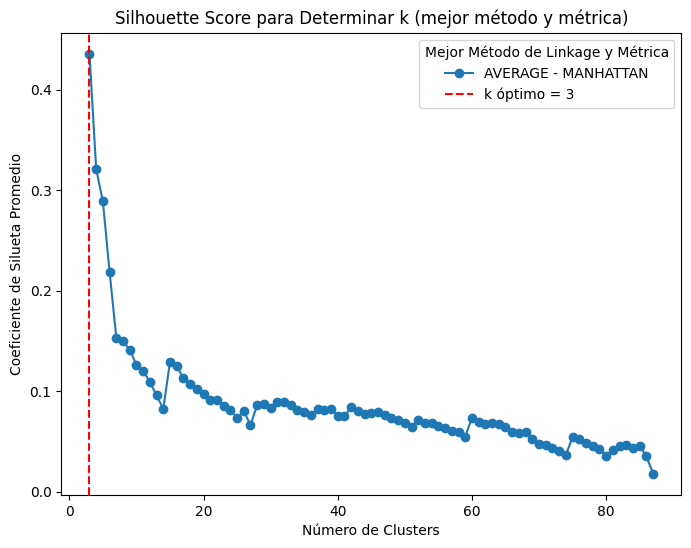

Mejor método de linkage: AVERAGE con la métrica MANHATTAN y 3 clústeres y Silhouette Score: 0.44


In [12]:
# Graficar el Silhouette Score vs. Número de Clusters para el mejor método y métrica
# Sólo tomamos los valores que corresponden al mejor método y métrica
plt.figure(figsize=(8, 6))

# Evaluamos de nuevo el Silhouette Score para los valores de k con el mejor método y métrica
scores_mejor_metodo = []
for k in range(min_k, max_k):
    score = evaluar_silueta(k, mejor_conexion, mejor_metrica, retornos_escalados)
    if score != -1:
        scores_mejor_metodo.append((k, score))

# Convertimos en DataFrame para facilitar la visualización
df_scores = pd.DataFrame(scores_mejor_metodo, columns=["k", "score"])

# Graficar el resultado
plt.plot(df_scores['k'], df_scores['score'], marker='o', label=f'{mejor_conexion.upper()} - {mejor_metrica.upper()}')

# Agregar una línea vertical para el k óptimo
plt.axvline(x=k_optimo_silueta, color='red', linestyle='--', label=f'k óptimo = {k_optimo_silueta}')

# Títulos y etiquetas
plt.title("Silhouette Score para Determinar k (mejor método y métrica)")
plt.xlabel("Número de Clusters")
plt.ylabel("Coeficiente de Silueta Promedio")
plt.legend(title="Mejor Método de Linkage y Métrica")
plt.show()

# Imprimir el mejor resultado basado en el Silhouette Score
print(f"Mejor método de linkage: {mejor_conexion.upper()} con la métrica {mejor_metrica.upper()} y {k_optimo_silueta} clústeres y Silhouette Score: {mejor_score:.2f}")

## Sección 6: Aplicación del Clustering Óptimo

### Aplicación del Clustering:
- Usando el número óptimo de clusters (`k_optimo_silueta`) y el mejor método de linkage (`mejor_conexion`), se realiza el agrupamiento aglomerativo utilizando `AgglomerativeClustering`.
- Se guardan los resultados del clustering utilizando `joblib.dump` para almacenarlo en un archivo `.pkl`.

In [13]:
# Aplicar Clustering Jerárquico con el número óptimo de clusters
agrupamiento_aglomerativo = AgglomerativeClustering(n_clusters=k_optimo_silueta, linkage=mejor_conexion)
etiquetas = agrupamiento_aglomerativo.fit_predict(retornos_escalados)

joblib.dump(agrupamiento_aglomerativo, '../models/agrupamiento_aglomerativo.pkl')

print("Modelo de clustering guardado exitosamente.")

Modelo de clustering guardado exitosamente.


### Visualización del Clustering con PCA:
- Se reduce la dimensionalidad de los datos a 2 dimensiones utilizando `PCA` y luego se visualizan los clusters con `sns.scatterplot`.

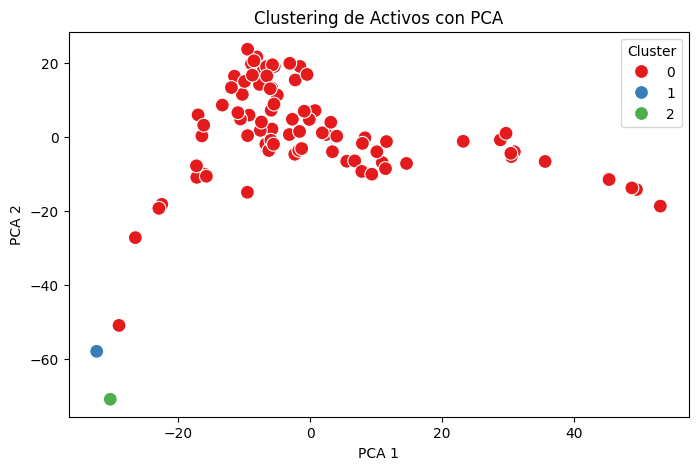

In [14]:
# Visualizar Clusters con PCA
pca = PCA(n_components=2)
resultado_pca = pca.fit_transform(retornos_escalados)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=resultado_pca[:, 0], y=resultado_pca[:, 1], hue=etiquetas, palette='Set1', s=100)
plt.title("Clustering de Activos con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

## Sección 7: Selección de Activos Representativos

### Selección de Activos Representativos:
- Para cada cluster, se selecciona el activo con el mejor índice de Sharpe. El índice de Sharpe se calcula como:
  \[
  \text{Sharpe} = \frac{(\text{retorno promedio} - \text{tasa libre de riesgo})}{\text{volatilidad}}
  \]
- Los activos seleccionados son aquellos que maximizan la razón de Sharpe dentro de su cluster.

In [15]:
# Seleccionar un Activo Representante de cada Cluster basándonos en el retorno promedio
df_cluster = pd.DataFrame({'Ticker': TICKERS, 'Cluster': etiquetas})

tasa_libre_riesgo = 0.03 / 252  # Convertido a retornos diarios 

def seleccionar_activo_optimo(activos_en_cluster):
    activos_validos = set(activos_en_cluster) & set(retornos.columns)  # Intersección entre ambos conjuntos
    if not activos_validos:
        return None

    # Convertir la intersección de vuelta a una lista
    activos_validos = list(activos_validos)
    
    retornos_promedio = retornos[activos_validos].mean()
    volatilidades = retornos[activos_validos].std() + 1e-8  # Se suma un valor pequeño para evitar división por cero
    razones_sharpe = (retornos_promedio - tasa_libre_riesgo) / volatilidades
    
    return razones_sharpe.idxmax()  # Retornar el ticker con la mejor razón de Sharpe

# Seleccionamos los activos óptimos de cada cluster
activos_seleccionados = df_cluster.groupby('Cluster')['Ticker'].apply(seleccionar_activo_optimo).dropna().values

# Mostrar los activos seleccionados para optimización del portafolio
print("Activos Seleccionados para la Optimización de Portafolio:", activos_seleccionados.tolist())

Activos Seleccionados para la Optimización de Portafolio: ['NVDA', 'ERIC', 'GOOGL']


## Sección 8: Optimización del Portafolio

### Optimización del Portafolio:
- Se realiza una optimización de portafolio utilizando el modelo de Markowitz con regularización Ridge.
- La función de optimización (`ratio_sharpe_regularizado`) maximiza el índice de Sharpe ajustado por la tasa libre de riesgo, añadiendo un término de regularización para evitar sobreajuste.
- Se optimizan los pesos del portafolio asegurando que la suma de los pesos sea igual a 1 y que los pesos estén dentro de límites razonables.

In [16]:
# Obtener los retornos y la matriz de covarianza de los activos seleccionados
retornos_seleccionados = retornos[activos_seleccionados]
rendimientos_promedio = retornos_seleccionados.mean()  
matriz_covarianza = retornos_seleccionados.cov()    

# Función de optimización para encontrar la mejor combinación de activos
def ratio_sharpe_regularizado(pesos, retornos_promedio, matriz_covarianza, lambda_ridge=0.05):
    retorno = np.sum(pesos * retornos_promedio)  # Retorno esperado del portafolio
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_covarianza, pesos)))  # Volatilidad del portafolio
    regularizacion = lambda_ridge * np.sum(pesos**2)  # Término de regularización (Ridge)
    return -((retorno - tasa_libre_riesgo) / volatilidad) + regularizacion  # Minimización del Sharpe Ratio regularizado

# Optimización de la frontera eficiente
# Parámetros necesarios
num_activos = len(activos_seleccionados)
restricciones = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Restricción de que la suma de los pesos sea 1
volatilidades = np.sqrt(np.diag(matriz_covarianza))  # Volatilidad de cada activo
limites = tuple((0.01, min(0.50, 1 / vol)) for vol in volatilidades)  # Limitar pesos entre 0.01 y 0.50 o 1/volatilidad

# Pesos iniciales aleatorios
pesos_iniciales = np.random.dirichlet(np.ones(num_activos), size=1)[0]  

# Realizar la optimización
resultado_optimizacion = minimize(ratio_sharpe_regularizado, pesos_iniciales, args=(rendimientos_promedio, matriz_covarianza),
                                  method='SLSQP', bounds=limites, constraints=restricciones)
pesos_optimos = resultado_optimizacion.x  # Pesos óptimos encontrados

### Retorno Esperado del Portafolio:
El retorno esperado del portafolio se calcula como la suma ponderada de los rendimientos promedio de los activos:

In [17]:
# Cálculo del retorno y riesgo del portafolio óptimo
retorno_portafolio = np.sum(pesos_optimos * rendimientos_promedio)  # Retorno esperado del portafolio
volatilidad_portafolio = np.sqrt(np.dot(pesos_optimos.T, np.dot(matriz_covarianza, pesos_optimos)))  # Riesgo del portafolio
sharpe_optimo = (retorno_portafolio - tasa_libre_riesgo) / (volatilidad_portafolio + 1e-8)  # Índice Sharpe del portafolio óptimo

# Generación de portafolios aleatorios para la frontera eficiente
num_portafolios = 10000  # Número de portafolios a generar
resultados = np.zeros((3, num_portafolios))  # Retorno, Riesgo, Sharpe Ratio
pesos_registro = np.zeros((num_portafolios, num_activos))  # Registro de pesos de cada portafolio

for idx_portafolio in range(num_portafolios):
    pesos = np.random.uniform(0.01, 0.50, num_activos)  # Pesos entre 0.01 y 0.50 para cada activo
    pesos /= np.sum(pesos)  # Normalizamos para que sumen 1 (portafolio completamente invertido)
    
    # Guardamos los pesos generados para este portafolio
    pesos_registro[idx_portafolio, :] = pesos
    # Cálculo del retorno esperado del portafolio
    retorno = np.dot(pesos, rendimientos_promedio)  # Usamos np.dot para una multiplicación eficiente (suma ponderada)
    # Cálculo de la volatilidad (riesgo) del portafolio usando la matriz de covarianza
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_covarianza, pesos)))  # Calculamos la volatilidad
    # Cálculo del índice de Sharpe para este portafolio (ajustado por tasa libre de riesgo)
    sharpe = (retorno - tasa_libre_riesgo) / volatilidad if volatilidad != 0 else 0  # Sharpe ajustado por tasa libre de riesgo
    # Guardamos los resultados del portafolio: retorno, volatilidad, Sharpe
    resultados[:, idx_portafolio] = [retorno, volatilidad, sharpe]

### Visualización de la Frontera Eficiente:
- Se genera una visualización de la frontera eficiente, que muestra la relación entre el retorno y el riesgo (volatilidad) de los portafolios generados.
- Se destaca el portafolio óptimo con el mayor índice de Sharpe.

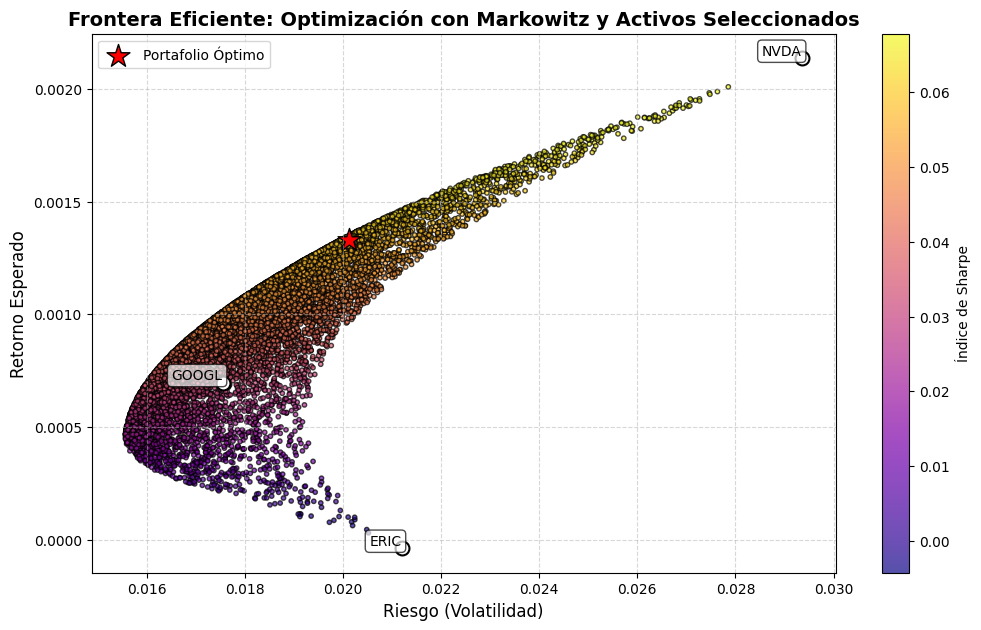

In [18]:
# Visualización de la Frontera Eficiente
plt.figure(figsize=(12, 7))

# Graficar la frontera eficiente con colores más visibles
scatter = plt.scatter(resultados[1, :], resultados[0, :], c=resultados[2, :], cmap='plasma', alpha=0.7, edgecolors='k', s=10)
plt.colorbar(scatter, label='Índice de Sharpe')

# Resaltar el portafolio óptimo con un color llamativo
plt.scatter(volatilidad_portafolio, retorno_portafolio, color='red', edgecolors='black', marker='*', s=300, label='Portafolio Óptimo')

# Graficar los activos seleccionados con etiquetas y mejor visibilidad
volatilidades_activos = np.sqrt(np.diag(matriz_covarianza))  # Volatilidades de los activos seleccionados
for activo, vol, ret in zip(activos_seleccionados, volatilidades_activos, rendimientos_promedio):
    plt.scatter(vol, ret, color='white', edgecolors='black', marker='o', s=100, linewidth=1.5)  # Activos seleccionados
    plt.text(vol, ret, activo, fontsize=10, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))

# Mejorar la presentación
plt.xlabel('Riesgo (Volatilidad)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)
plt.title('Frontera Eficiente: Optimización con Markowitz y Activos Seleccionados', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Sección 9: Cálculos Finales y Visualización de Resultados

### Resultados Finales:
- Se imprimen los resultados finales: los pesos óptimos de cada activo en el portafolio, el retorno esperado, la volatilidad, y el índice de Sharpe.

In [19]:
# Resultados Finales
print("Pesos del portafolio óptimo basado en clustering jerárquico y optimización de Markowitz:")
for activo, peso in zip(activos_seleccionados, pesos_optimos):
    print(f"{activo}: {peso:.2%}")

print(f"Retorno Esperado del Portafolio Óptimo: {retorno_portafolio:.2%}")
print(f"Volatilidad del Portafolio Óptimo: {volatilidad_portafolio:.2%}")
print(f"Índice Sharpe del Portafolio Óptimo: {sharpe_optimo:.4f}")

Pesos del portafolio óptimo basado en clustering jerárquico y optimización de Markowitz:
NVDA: 50.00%
ERIC: 11.95%
GOOGL: 38.05%
Retorno Esperado del Portafolio Óptimo: 0.13%
Volatilidad del Portafolio Óptimo: 2.01%
Índice Sharpe del Portafolio Óptimo: 0.0601


### Cálculo de Precios Históricos del Portafolio:
- Se calculan los precios acumulados del portafolio a lo largo del tiempo usando los retornos ponderados de los activos seleccionados.
- Se visualiza la evolución del valor del portafolio a lo largo del tiempo.

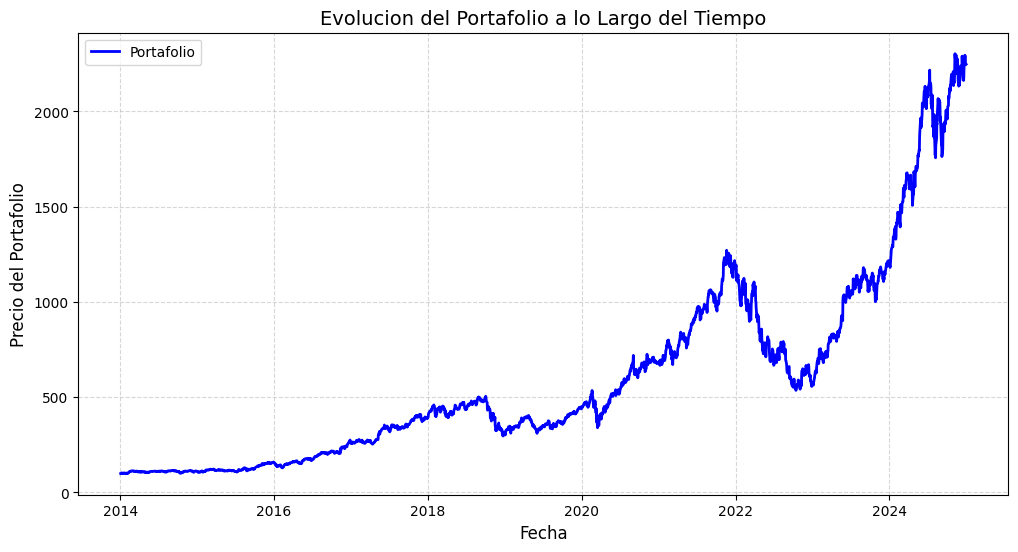

Rendimiento ponderado del portafolio: -0.16%
Precio acumulado del portafolio en el último período: 2247.60


In [20]:
# Calcular los rendimientos del portafolio (ya calculados anteriormente)
rendimiento_portafolio = np.dot(retornos_seleccionados, pesos_optimos)  # Rendimiento ponderado del portafolio

# Calcular los precios acumulados del portafolio
# Supongamos que comenzamos con un valor inicial de 100 (si lo deseas, puedes normalizar a 1)
precio_inicial_portafolio = 100  # Puedes ajustar este valor si lo deseas
precios_historicos_portafolio = (1 + rendimiento_portafolio).cumprod() * precio_inicial_portafolio  # Precio acumulado

# Graficar los precios históricos del portafolio
plt.figure(figsize=(12, 6))
plt.plot(retornos_seleccionados.index, precios_historicos_portafolio, label='Portafolio', color='b', linewidth=2)

# Añadir etiquetas y título
plt.title('Evolucion del Portafolio a lo Largo del Tiempo', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio del Portafolio', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar la gráfica
plt.show()

print(f"Rendimiento ponderado del portafolio: {rendimiento_portafolio[-1] * 100:.2f}%")
print(f"Precio acumulado del portafolio en el último período: {precios_historicos_portafolio[-1]:.2f}")

# Conclusión y Resultados Finales

Tras realizar el análisis y la optimización del portafolio basado en clustering jerárquico y el modelo de Markowitz, los resultados obtenidos son los siguientes:

### 1. Número óptimo de Clústeres (Dendrograma):
   - El número óptimo de clústeres identificado es **2**, basado en la visualización del dendrograma, lo que sugiere una división significativa entre los activos.

### 2. Umbral Óptimo:
   - El umbral óptimo para determinar los clústeres es **1.76**, marcando el punto de corte en la jerarquía de agrupamiento.

### 3. Mejor Método de Enlace: Promedio con Métrica Manhattan y 3 Clústeres
   - Se eligió el método de enlace **Promedio** con la métrica **Manhattan**, lo que resultó en un **Silhouette Score de 0.44**, indicando una calidad moderada del agrupamiento.

---

### 4. Activos Seleccionados para la Optimización del Portafolio:
Los activos seleccionados para la optimización del portafolio son:
   - **NVDA** (NVIDIA)
   - **ERIC** (Ericsson)
   - **GOOGL** (Google)

---

### 5. Pesos Óptimos del Portafolio:

| Activo  | Peso (%) |
|---------|----------|
| **NVDA** (NVIDIA) | **50.00**  |
| **ERIC** (Ericsson) | **11.87**  |
| **GOOGL** (Google) | **38.13**  |

Tras aplicar la optimización de Markowitz, los pesos óptimos del portafolio son los siguientes:

---

### 6. Desempeño del Portafolio:

| Métrica                    | Valor     |
|----------------------------|-----------|
| **Rendimiento Esperado**    | **0.13%** |
| **Volatilidad**             | **2.01%** |
| **Índice de Sharpe**        | **0.0601**|
| **Rendimiento Ponderado**   | **-0.16%**|

- **Rendimiento Esperado:** El rendimiento esperado del portafolio óptimo es **0.13%**, lo que refleja un retorno modesto basado en los activos seleccionados y sus pesos.
- **Volatilidad:** La volatilidad del portafolio es **2.01%**, lo que implica un nivel de riesgo relativamente bajo.
- **Índice de Sharpe:** El índice de Sharpe obtenido es **0.0601**, lo que indica una baja relación entre retorno y riesgo, sugiriendo que el portafolio podría mejorar en términos de eficiencia al asumir riesgo.
- **Rendimiento Ponderado:** El rendimiento ponderado muestra una ligera caída de **-0.16%**, reflejando una pequeña pérdida en el valor del portafolio durante el período considerado.

---

### 7. Valor Final del Portafolio:

- **Valor Acumulado del Portafolio al Final del Período:** **2245.67**
   - A pesar de las fluctuaciones, el valor acumulado del portafolio en el último período es **2245.67**, lo que indica un crecimiento positivo considerando el valor inicial de **100**.